This notebook contains some analysis and visualization of data collected from the 2015 National Survey on Drug Use and Health (NSDUH), a massive annually-conducted questionnaire administered to a large cross-section of the US investigating drug abuse and their effects on people's wellbeing. The file used is quite large at almost 400MB, and contains 2,600 columns across nearly 60,000 entries. This series is part of my own investigations on drug use in the United States.

In [1]:
import pandas as pd

# importing dataset, may take a few minutes to load due to size
df = pd.read_csv("datasets/NSDUH2015.tsv", sep="\t")

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (2501) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


This section will be analyzing the prevalence and frequency of substance use. Later I will break these down by demographics such as gender, race, age, and income to see which groups may be more prone to usage of certain drugs.

# HOW MANY PEOPLE HAVE TRIED CERTAIN DRUGS?

The NSDUH contains many different attributes that can be used to measure different levels of substance use. I will start with the most basic metric: whether or not a participant has ever tried a given drug. The NSDUH codebook provides very cut-and-dry attributes for this metric. Here's a dataframe:

In [2]:
# slicing the columns needed
ever_tried = df[["TOBFLAG", "ALCFLAG", "MRJFLAG", "LSDFLAG", "PSILCY2", "ECSTMOFLAG", "KETMINFLAG", "COLDFLGR", 
                "PNRNMFLAG", "TRQNMFLAG", "STMNMFLAG", "SEDNMFLAG", "COCFLAG", "METHAMFLAG", "HERFLAG", 
                 "CRKFLAG", "PCPFLAG"]]

# renaming the variables appropriately
ever_tried.columns = ["Tobacco", "Alcohol", "Marijuana", "LSD", "Magic Mushrooms", "Ecstasy / Molly", "Ketamine", 
                     "DXM / Cold Meds", "Prsc. Painkillers", "Prsc. Tranquilizers", "Prsc. Stimulants", 
                      "Prsc. Hypnotics", "Cocaine", "Meth", "Heroin", "Crack", "PCP"]

ever_tried[:5]

,Tobacco,Alcohol,Marijuana,LSD,Magic Mushrooms,Ecstasy / Molly,Ketamine,DXM / Cold Meds,Prsc. Painkillers,Prsc. Tranquilizers,Prsc. Stimulants,Prsc. Hypnotics,Cocaine,Meth,Heroin,Crack,PCP
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,1,1,0,0,0,0,0,1,0,0,1,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now we have a binary matrix of all 50,000+ survey respondents and whether or not they've identified as trying each listed drug, where a zero in the matrix means they're marked as having used the identified drug before and a one meaning they haven't. I attempted to group the substances in a somewhat logical order to better identify trends in our graphs: grouped by legal drugs first, then hallucinogens, then prescription drugs, and hard drugs last.

The drug categories provided for this metric, with usage percentages as identified in the codebook, are: 
- tobacco (in any of its form), 56.2%,
- alcohol, 72.8%,
- marijuana or hashish (in any of its forms), 42.5%,
- LSD (acid), 7.9%,
- psilocybin (magic) mushrooms, 8.1%,
- ecstasy, molly, or any variant, 8.0%,
- ketamine, 1.3%,
- over-the-counter cold medicine (DXM), 4.3%,
- non-doctor-approved misuse of prescription pain relievers (opiates), 11.1%,
- non-doctor-approved misuse of prescription tranquilizer (benzos or muscle relxants), 4.5%,
- non-doctor-approved misuse of prescription stimulants, mostly amphetamine, 5.0%,
- non-doctor-approved misuse of prescription sedatives (mostly sleeping pills but also barbituates), 2.0%,
- cocaine, 11.8%,
- methamphetamine, 4.6%,
- heroin, 1.7%,
- crack or freebase cocaine, 2.8%,
- PCP, 1.5%.

[Unfortunately due to the way the survey was constructed, we cannot isolate specifically for benzodiazepine, barbituate, muscle relaxant, or amphetamine usage, only their broader categories. We will be able to do that in some other metrics though. There are also some other drugs available in this metric including: mescaline, peyote, GHB, salvia, DMT, and inhalants. These were excluded out of lower importance and lower use rates but I'll look at them at the end.]

To start, here's a simple visualization of which drugs have been tried by the entire US population.

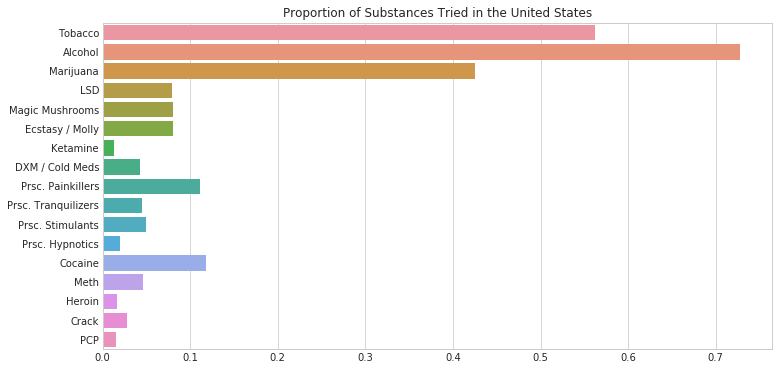

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
%matplotlib inline

plt.figure(figsize=(12,6))
ax = sns.barplot(orient="h", ci=None, data=ever_tried)
ax.set_title("Proportion of Substances Tried in the United States")

This quick and dirty metric gives us a very rough idea of what drugs have been used in the United States through all demographics including all income groups, genders, and ages as low as 12 years old. Drug use varies significantly by these factors so I will be isolating for numerous different demographic categories later.

With that said, let's start with a heat map correlation matrix to see if the usage of certain drugs can possibly predict the usage of other drugs and how their usage rates interact with another.

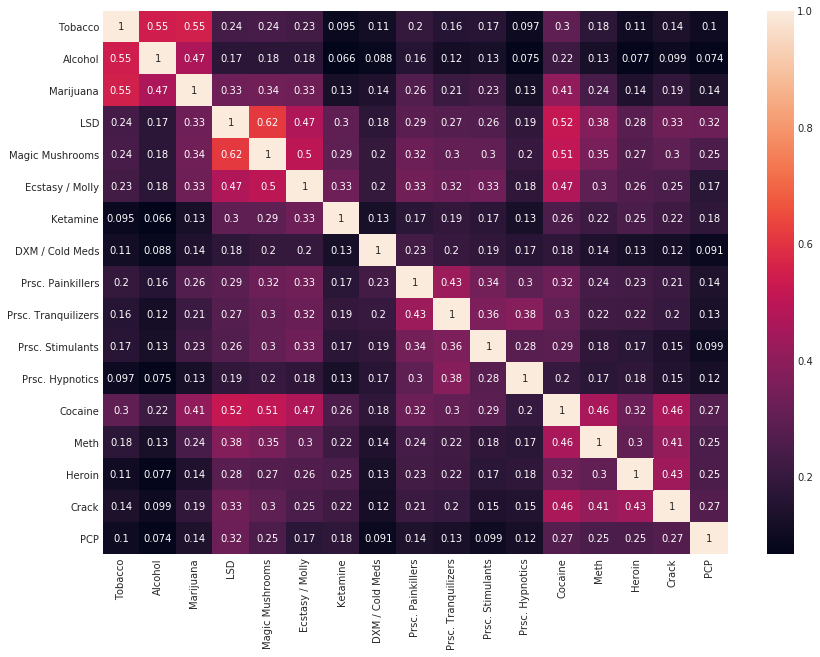

In [4]:
plt.figure(figsize=(14,10))
sns.heatmap(ever_tried.corr(),annot=True)

Trends can be seen above. The most noticiable observation is that most substances of any sort have a moderate to high correlation with each other, with drugs in a similar category having the highest correlation. That is, the odds that an individual has tried a specific illicit substance is higher if they have tried other illicit substances. 

That said, this plot is only showing when a substance has ever been used before, even once. It does not take into account how long ago this drug was used or how many times it was used. If we are looking for more modern trends in drug usage, this is less useful considering more than 1/3 of the respondents are over the age of 35 and may not have even used these substances in decades. 

So alternately, we can analyze what drugs have been tried in the past year if we want to learn about more recent trends. The NSDUH also provides attributes when asking for substance usage in the past year, and not only that, they provide slightly different categories for substances in this metric, so this will allow us to home in on some more specific classifiers of drugs. 

Let's create a new dataframe with substances used in the past year.

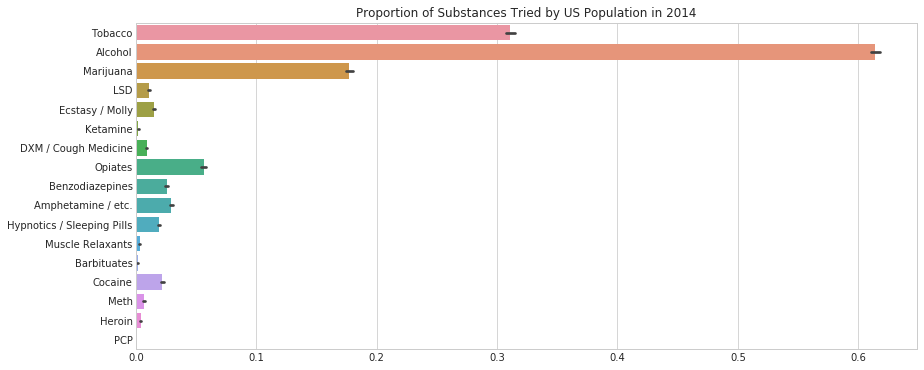

In [5]:
used_past_year = df[["TOBYR", "ALCYR", "MRJYR", "LSDYR", "ECSTMOYR", "KETMINYR", "COLDYRR", "PNRNMYR", 
                     "TRBENZPYMU", "AMMEPDPYMU", "SEDOTANYR2", "MUSRLXPYMU", "BARBITAPYU","COCYR", "METHAMYR", 
                     "HERYR", "PCPYR"]]
used_past_year.columns = ["Tobacco", "Alcohol", "Marijuana", "LSD", "Ecstasy / Molly", "Ketamine", 
                          "DXM / Cough Medicine", "Opiates", "Benzodiazepines", 
                          "Amphetamine / etc.", "Hypnotics / Sleeping Pills", "Muscle Relaxants", 
                          "Barbituates", "Cocaine", "Meth", "Heroin", "PCP"]

plt.figure(figsize=(14,6))
ax = sns.barplot(orient="h", data=used_past_year)
ax.set_title("Proportion of Substances Tried by US Population in 2014")

With this we can see some differences between lifetime use and use in the past year. Illicit drug use like cocaine or LSD is down, while it appears that prescription drugs like opiates, benzos, and amphetamine are higher in comparison. This can either mean: prescription drugs are being abused more in recent years compared to prior years or that prescription drugs are abused more frequently / in higher quantities than other drugs. Likely a combination of the two.

Here's the corresponding heatmap for substances tried in the past year.

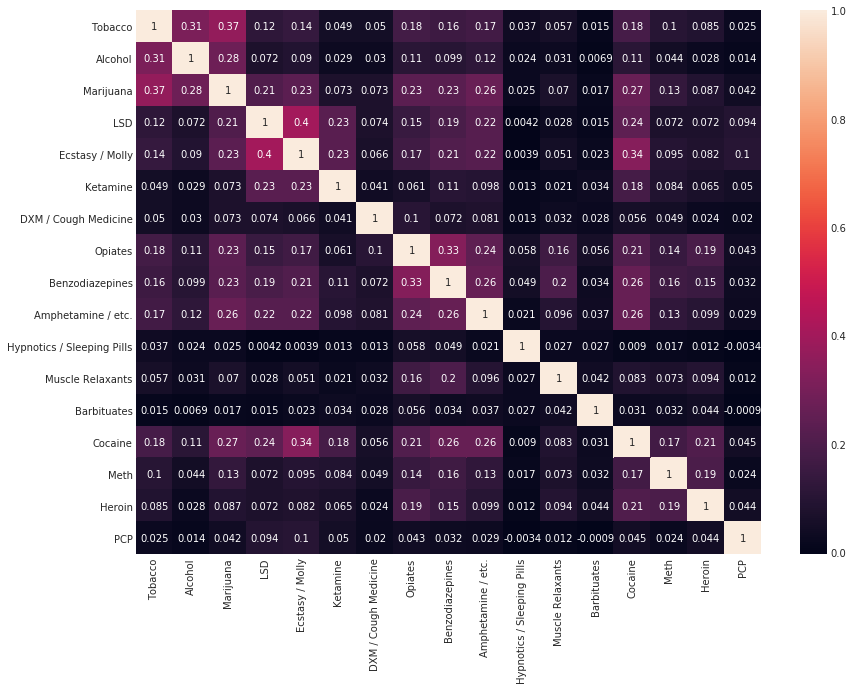

In [6]:
plt.figure(figsize=(14,10))
sns.heatmap(used_past_year.corr(),annot=True)

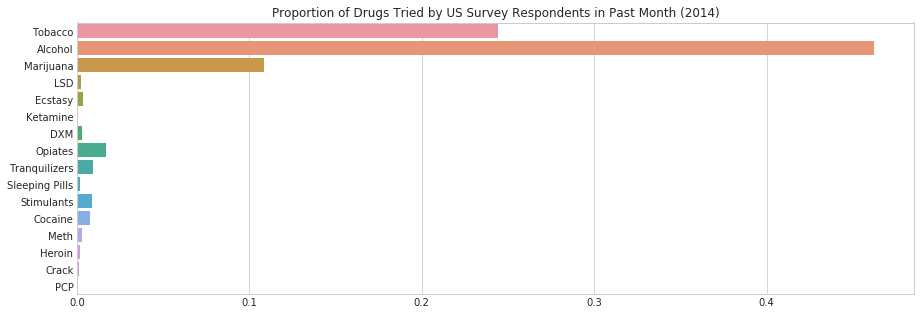

In [7]:
used_past_month = df[["TOBMON", "ALCMON", "MRJMON", "LSDMON", "ECSTMOMON", "KETMINMON", "COLDMONR", "PNRNMMON", 
                      "TRQNMMON", "SEDNMMON", "STMNMMON", "COCMON", "METHAMMON", "HERMON", "CRKMON", "PCPMON"]]
used_past_month.columns = ["Tobacco", "Alcohol", "Marijuana", "LSD", "Ecstasy", "Ketamine", "DXM", 
                           "Opiates", "Tranquilizers", "Sleeping Pills", "Stimulants", "Cocaine", "Meth", 
                           "Heroin", "Crack", "PCP"]

plt.figure(figsize=(15,5))
ax = sns.barplot(orient="h", data=used_past_month, ci=None)
ax.set_title("Proportion of Drugs Tried by US Survey Respondents in Past Month (2014)")

Monthly alcohol and tobacco use dwarf illicit drug use by such a huge amount that it's hard to even see the usage rate of illicit/prescription drugs on any graphs. Let's make a new graph with them removed to zoom in specifically on illicit substances.

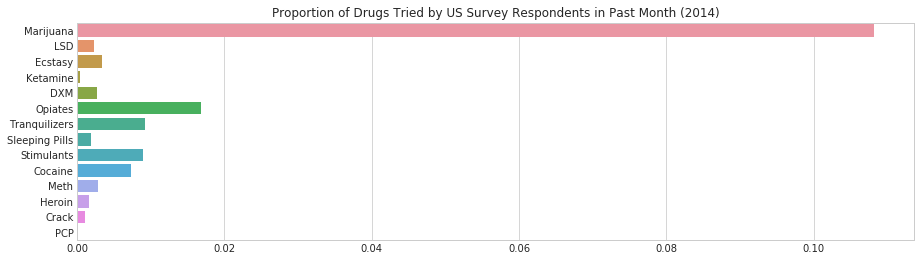

In [8]:
used_past_month2 = df[["MRJMON", "LSDMON", "ECSTMOMON", "KETMINMON", "COLDMONR", "PNRNMMON", "TRQNMMON", "SEDNMMON", "STMNMMON", "COCMON", "METHAMMON", "HERMON", "CRKMON", "PCPMON"]]
used_past_month2.columns = ["Marijuana", "LSD", "Ecstasy", "Ketamine", "DXM", "Opiates", "Tranquilizers", "Sleeping Pills", "Stimulants", "Cocaine", "Meth", "Heroin", "Crack", "PCP"]

plt.figure(figsize=(15,4)) # plot re-size
ax = sns.barplot(orient="h", data=used_past_month2, ci=None)
ax.set_title("Proportion of Drugs Tried by US Survey Respondents in Past Month (2014)")

We can also make a correlation matrix heatmap for "used_past_month" if we wanted to, but I'm going to exclude it considering it's not terribly different or more illuminating than the "used_past_year". In fact, the entire "used_past_month" metric is really not that different from "used_past_year". 

So instead something that might be more illuminating would be the quantity that someone uses in a month. Luckily, for some drug classes, the NSDUH provides an attribute where respondents report the number of times they've used a drug in the past month. Here's a dataframe with the substances for which this metric is reported:

In [9]:
heavy_use = df[["ALCMDAYS", "MRJMDAYS", "HALLNDAYPM", "PNRNDAYPM", "TRQNDAYPM", "STMNDAYPM", "SEDNDAYPM",
                "COCMDAYS", "METHNDAYPM", "IRHERFM"]]
heavy_use.columns = ["Alcohol", "Marijuana", "Hallucinogens", "Opiates", "Tranquilizers", "Amphetamine", 
                      "Sleeping Pills", "Cocaine", "Meth", "Heroin"]
heavy_use[:6]

,Alcohol,Marijuana,Hallucinogens,Opiates,Tranquilizers,Amphetamine,Sleeping Pills,Cocaine,Meth,Heroin
0,1,5,5,5,5,5,5,5,5,91
1,3,4,5,5,5,5,5,5,5,91
2,5,5,5,5,5,5,5,5,5,91
3,5,5,5,5,5,5,5,5,5,91
4,5,5,5,5,5,5,5,5,5,91
5,3,5,5,5,5,5,5,5,5,91


The chart above is coded into categories where the numbers 1 through 4 refer to specific categories of usage in the past month, where 5 refers to a drug having not been used in the past month at all. The exception is for "Heroin", which I had to use a slightly different reference code than the others, so I'll have to take care of it on its own. 

Now I just want to make this a simple binary matrix like the previous three metrics where a "0" means that the respondent is not a heavy recent user of a given drug and a "1" means that the respondent is a heavy user of a given drug. We'll replace the entries in the "heavy_use" dataframe to make it happen; the following code will make sense if you look at the variables used in the "heavy_use" dataframe in the NSDUH codebook. We will transform this dataframe so that a '0' means an indvidual has used a given drug 3 or more times in the past month and a '1' means they have not.

In [10]:
heavy_use["Heroin"].replace({91:0, 93:0, 1:0, 2:0}, inplace=True)
heavy_use["Heroin"][heavy_use["Heroin"]>0] = 2
heavy_use.replace({5:0, 1:0, 2:1, 3:1, 4:1}, inplace=True)

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:3924: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2862: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.5/d

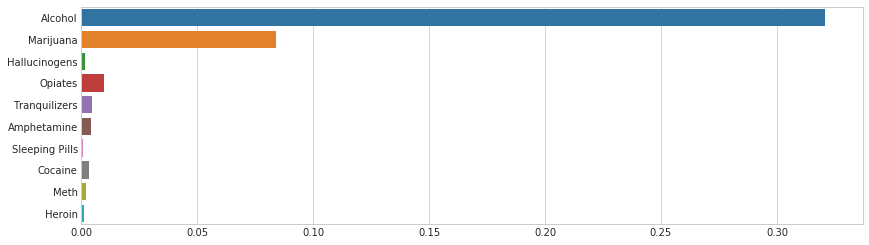

In [11]:
plt.figure(figsize=(14,4))
sns.barplot(orient="h", data=heavy_use, ci=None)

From here we can now see what drugs are seeing heavy use by individuals in the United States. Like the monthly use chart, heavy alcohol use dwarfs the usage of other drugs, so let's see this graph with only illicit drugs.

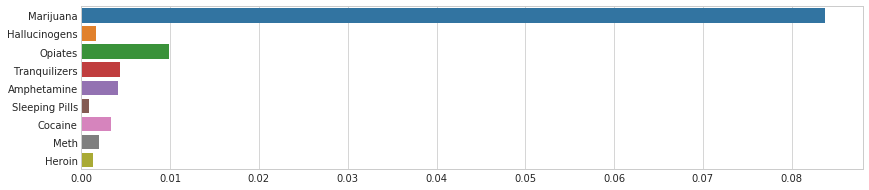

In [12]:
heavy_use2 = heavy_use[["Marijuana", "Hallucinogens", "Opiates", "Tranquilizers", "Amphetamine", 
                      "Sleeping Pills", "Cocaine", "Meth", "Heroin"]]

plt.figure(figsize=(14,3))
sns.barplot(orient="h", data=heavy_use2, ci=None)

# USING SPECIFIC DEMOGRAPHICS

The above charts give us a feel for general drug use across the entire US population. However, what about specific groups of people? The NSDUH includes hundreds of metrics about each individual that we can look at ranging from identities to mental health to physical health to even questions about childhood experiences. For this section we'll start with the most basic possible demographics: sex, race, age, income, and the most recently added demographic to the NSDUH, sexuality.

In [13]:
# function that adds my desired demographic columns, converts their coding into text, and transforms dataframe into
# long-form 
def demographics_transform(data):
    new_data = data.assign(SEX = df["IRSEX"], RACE = df["NEWRACE2"], AGE = df["CATAG3"], INCOME = df["INCOME"], 
                           SEXUALITY=df["SEXIDENT"])
    new_data["SEX"].replace({1:"Male", 2:"Female"}, inplace=True)
    new_data["RACE"].replace({1:"White", 2:"Black", 3:"Native American", 4:"Pacific Islander", 
                           5:"Asian", 6:"Mixed Race", 7:"Hispanic"}, inplace=True)
    new_data["AGE"].replace({1:"12-17", 2:"18-25", 3:"26-34", 4:"35-49", 5:"50+"}, inplace=True)
    new_data["INCOME"].replace({1:"<$20K", 2:"$20K-$50K", 3:"$50K-$75K", 4:"$75K+"}, inplace=True)
    new_data["SEXUALITY"].replace({1:"Straight", 2:"Gay/Bisexual", 3:"Bisexual/Gay", 
                                   94:"Unsure", 97:"Refuse to Answer", 98:"Unsure", 
                                   99:"Refuse to Answer"}, inplace=True)
    new_data = pd.melt(new_data, id_vars=["SEX", "RACE", "AGE", "INCOME", "SEXUALITY"], 
                        var_name="drug", value_name="drug use")
    return new_data

Now we'll apply this transformation to our first metric: whether or not an individual has ever tried a specific drug, and now we'll see them broken down by these metrics.

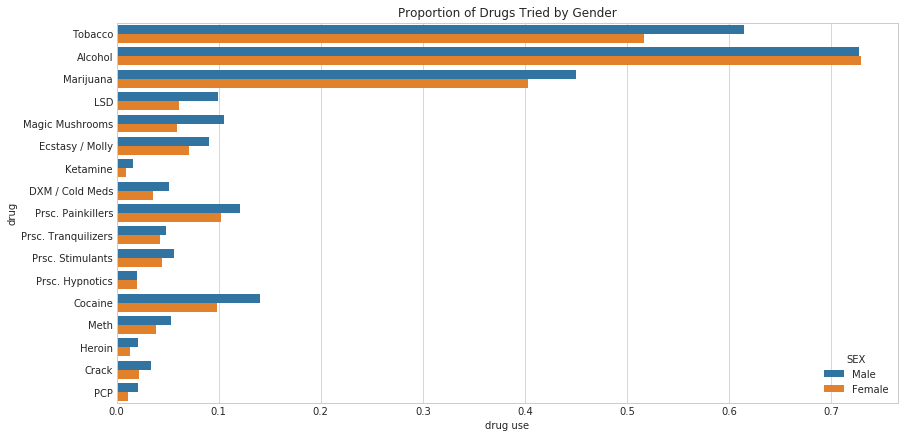

In [14]:
ever_tried = demographics_transform(ever_tried)

plt.figure(figsize=(14,7))
ax = sns.barplot(orient="h", y="drug", x="drug use", hue="SEX", ci=None, data=ever_tried)
ax.set_title("Proportion of Drugs Tried by Gender")

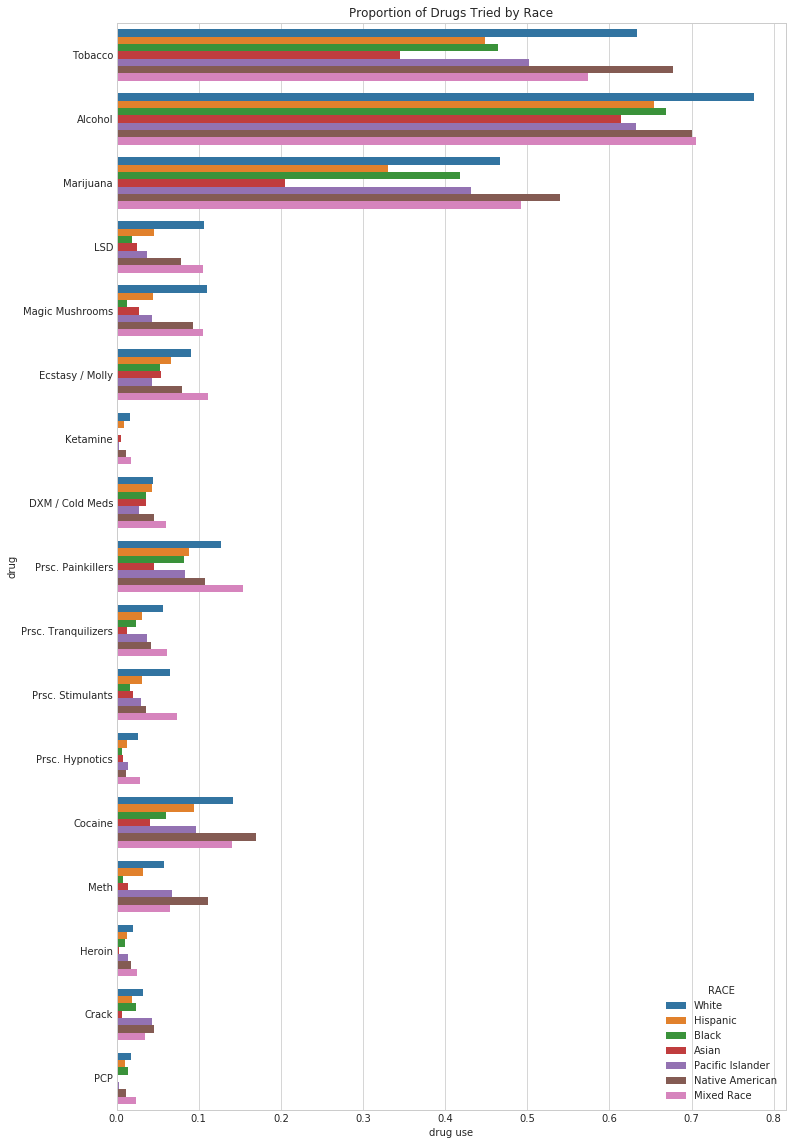

In [15]:
plt.figure(figsize=(12,20)) # plot re-size
ax = sns.barplot(orient="h", y="drug", x="drug use", hue="RACE", 
            hue_order=["White", "Hispanic", "Black", "Asian", "Pacific Islander", "Native American", "Mixed Race"],
            ci=None, data=ever_tried)
ax.set_title("Proportion of Drugs Tried by Race")

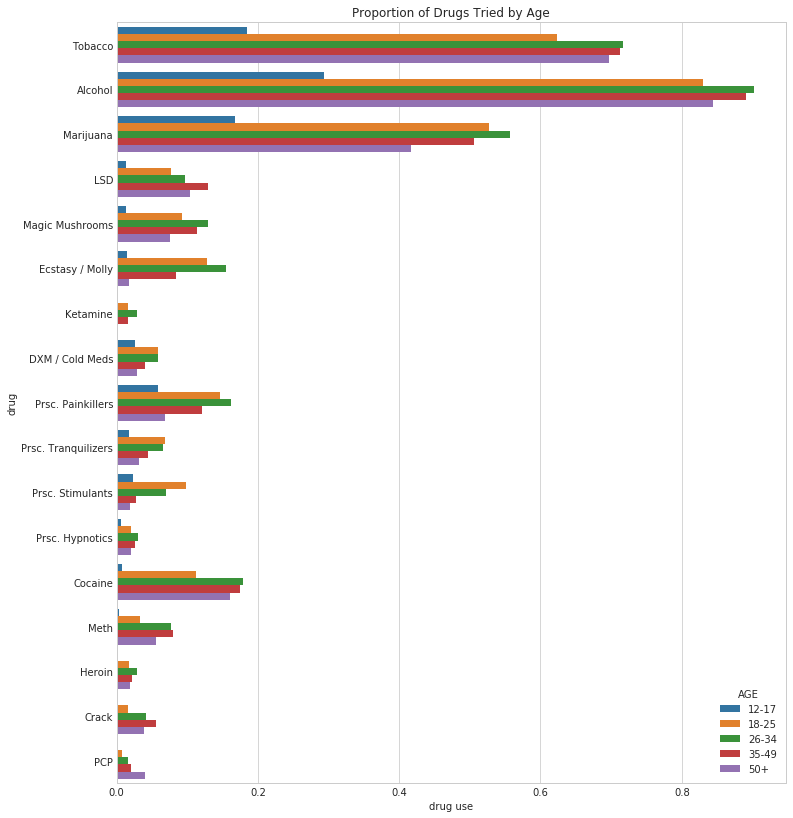

In [16]:
plt.figure(figsize=(12,14)) # plot re-size
ax = sns.barplot(orient="h", y="drug", x="drug use", hue="AGE", hue_order=["12-17", "18-25", "26-34", "35-49", 
                                                                  "50+"], ci=None, data=ever_tried)
ax.set_title("Proportion of Drugs Tried by Age")

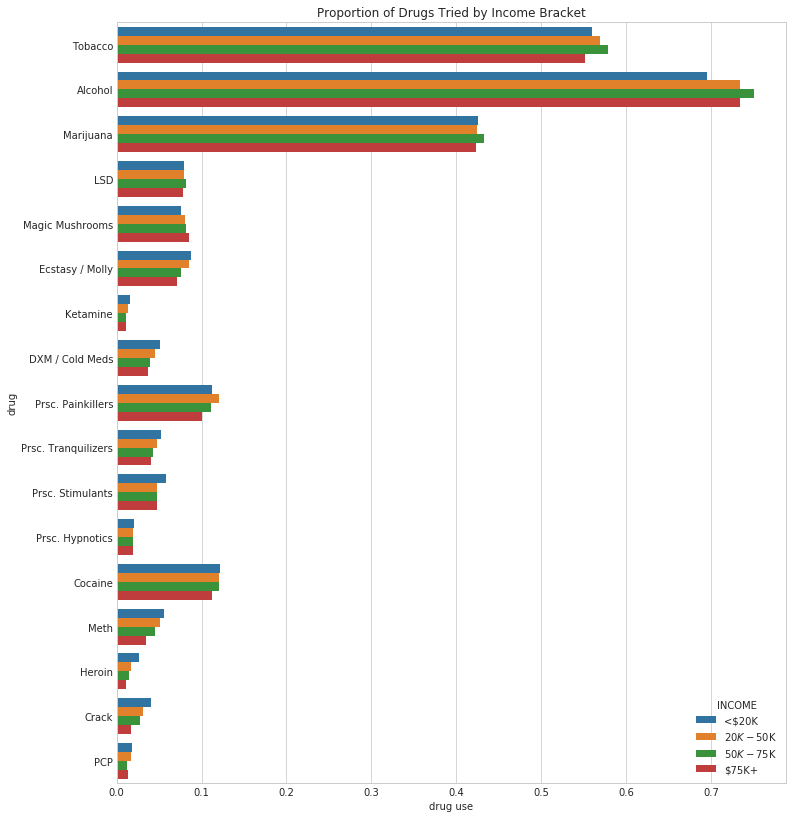

In [17]:
plt.figure(figsize=(12,14)) # plot re-size
ax = sns.barplot(orient="h", y="drug", x="drug use", hue="INCOME", 
            hue_order=["<$20K", "$20K-$50K", "$50K-$75K", "$75K+"], ci=None, data=ever_tried)
ax.set_title("Proportion of Drugs Tried by Income Bracket")

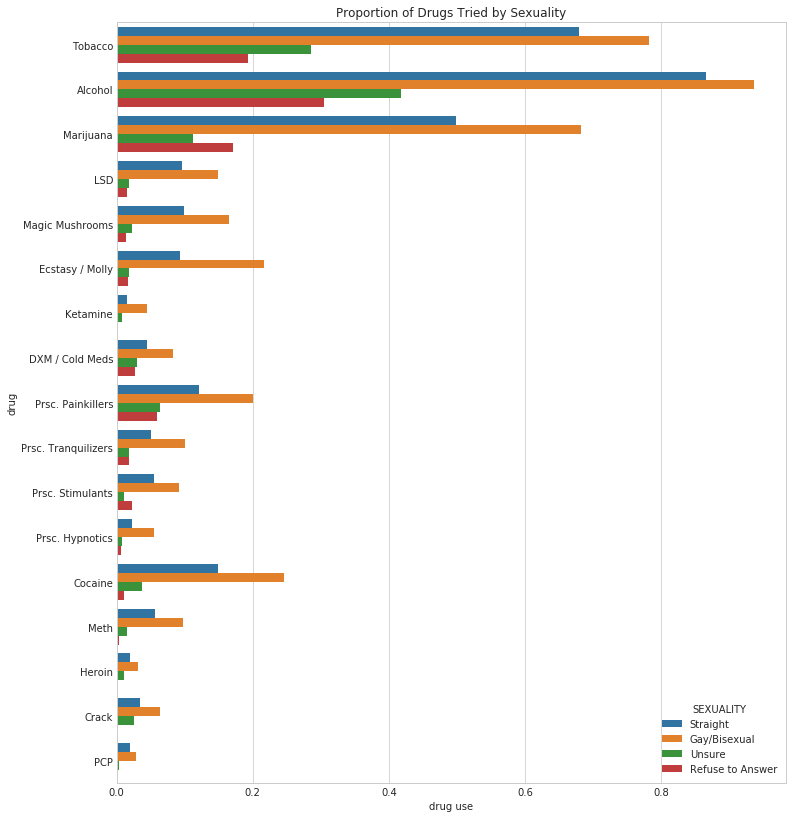

In [18]:
plt.figure(figsize=(12,14)) # plot re-size
ax = sns.barplot(orient="h", y="drug", x="drug use", hue="SEXUALITY", 
            ci=None, data=ever_tried, hue_order=["Straight", "Gay/Bisexual", "Unsure", "Refuse to Answer"])
ax.set_title("Proportion of Drugs Tried by Sexuality")

Fascinating stuff. Now let's look at what drugs have been tried in the past YEAR based on these same demographics.

In [19]:
# recreating the dataframe because we need to take out some drug categories that have too few users to create
# any meaningful data upon being split by demographic
used_past_year2 = df[["TOBYR", "ALCYR", "MRJYR", "LSDYR", "ECSTMOYR", "COLDYRR", "PNRNMYR", 
                     "TRBENZPYMU", "AMMEPDPYMU", "SEDOTANYR2","COCYR", "METHAMYR", 
                     "HERYR"]]
used_past_year2.columns = ["Tobacco", "Alcohol", "Marijuana", "LSD", "Ecstasy / Molly",  
                          "DXM / Cough Medicine", "Opiates", "Benzodiazepines", 
                          "Amphetamine / etc.", "Hypnotics / Sleeping Pills", 
                          "Cocaine", "Meth", "Heroin"]

used_past_year2 = demographics_transform(used_past_year2)

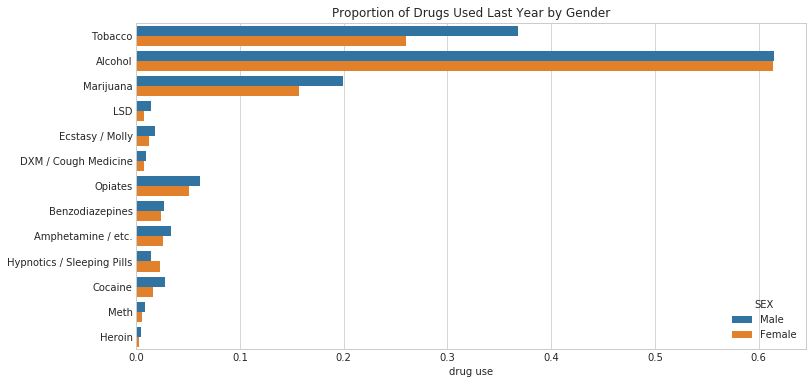

In [20]:
plt.figure(figsize=(12,6)) # plot re-size
ax = sns.barplot(orient="h", y="drug", x="drug use", hue="SEX", ci=None, data=used_past_year2)
ax.set_ylabel('') 
ax.set_title("Proportion of Drugs Used Last Year by Gender")

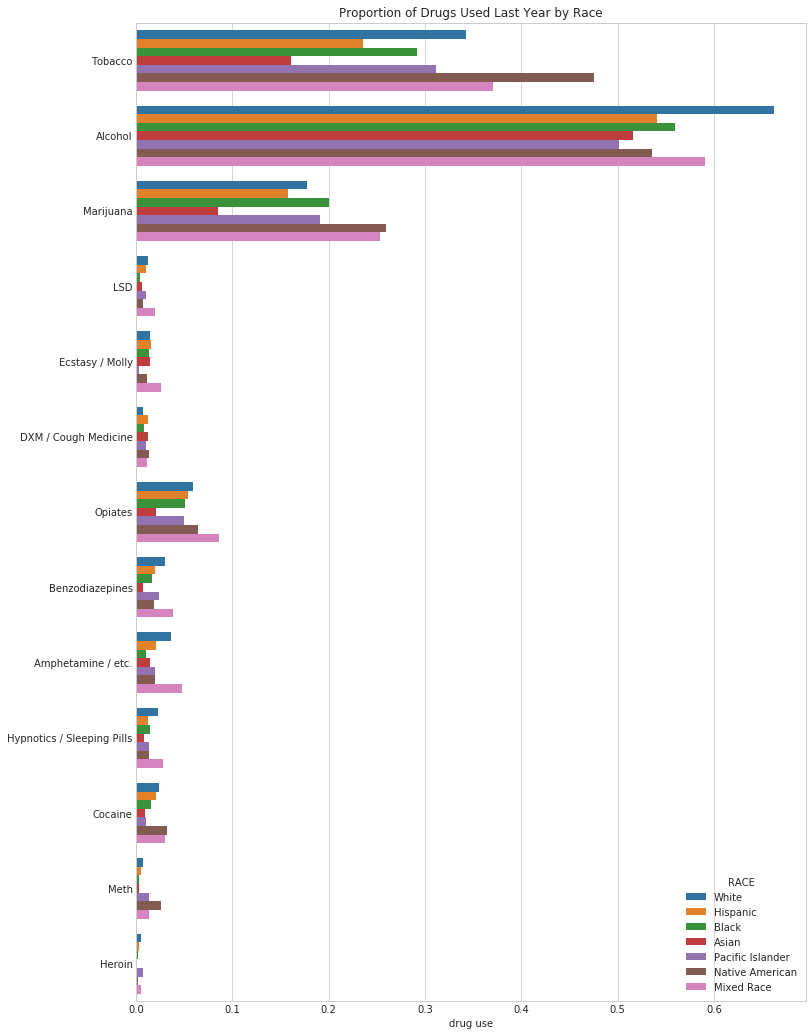

In [21]:
plt.figure(figsize=(12,18)) # plot re-size
ax = sns.barplot(orient="h", y="drug", x="drug use", hue="RACE", 
            hue_order=["White", "Hispanic", "Black", "Asian", "Pacific Islander", "Native American", "Mixed Race"],
            ci=None, data=used_past_year2)
ax.set_ylabel('') 
ax.set_title("Proportion of Drugs Used Last Year by Race")

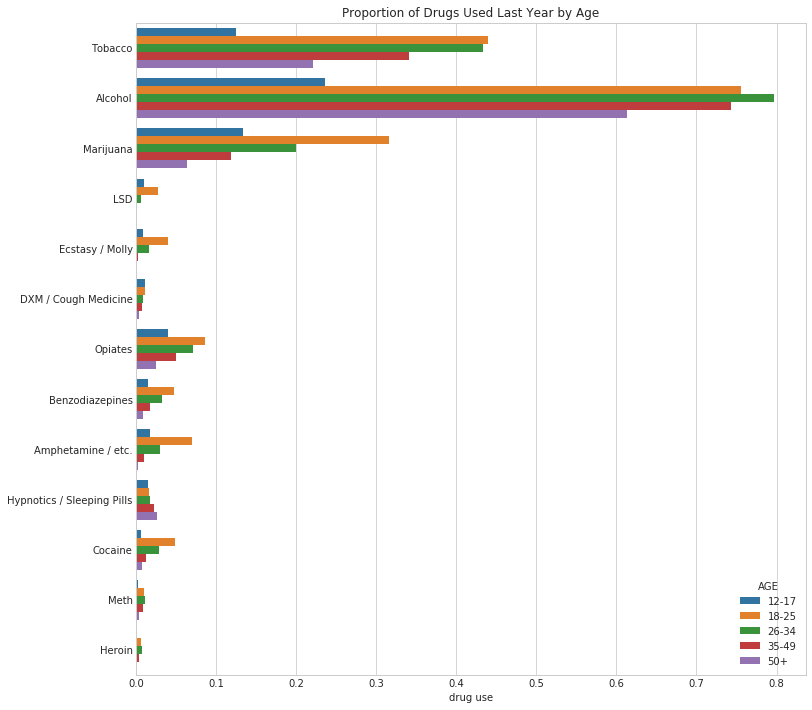

In [22]:
plt.figure(figsize=(12,12)) # plot re-size
ax = sns.barplot(orient="h", y="drug", x="drug use", hue="AGE", hue_order=["12-17", "18-25", "26-34", "35-49", 
                                                                  "50+"], ci=None, data=used_past_year2)
ax.set_ylabel('') 
ax.set_title("Proportion of Drugs Used Last Year by Age")

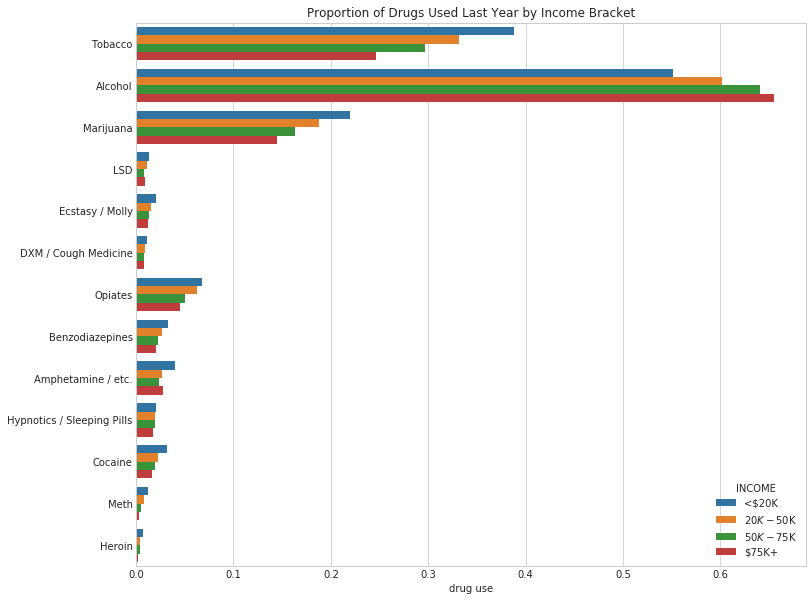

In [23]:
plt.figure(figsize=(12,10)) # plot re-size
ax = sns.barplot(orient="h", y="drug", x="drug use", hue="INCOME", 
            hue_order=["<$20K", "$20K-$50K", "$50K-$75K", "$75K+"], ci=None, data=used_past_year2)
ax.set_ylabel('') 
ax.set_title("Proportion of Drugs Used Last Year by Income Bracket")

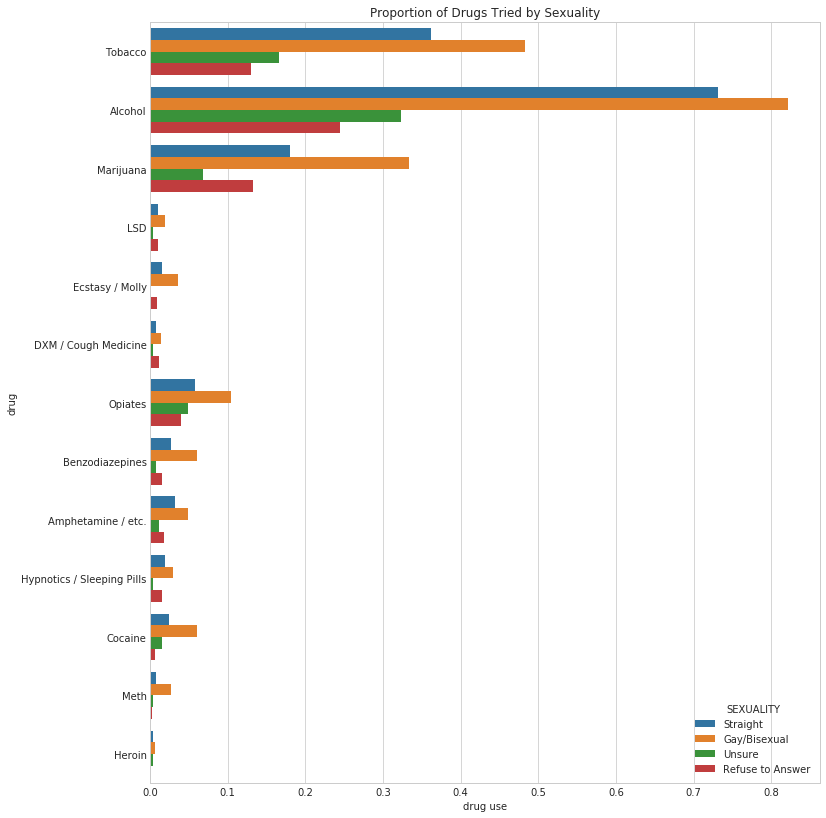

In [24]:
plt.figure(figsize=(12,14)) # plot re-size
ax = sns.barplot(orient="h", y="drug", x="drug use", hue="SEXUALITY", 
                 hue_order=["Straight", "Gay/Bisexual", "Unsure", "Refuse to Answer"],
            ci=None, data=used_past_year2)
ax.set_title("Proportion of Drugs Tried by Sexuality")

Lastly we will look at what demographics have people considered "heavy users" (defined as using a given drug 3+ more times in the past month) broken down by gender, race, age, and income bracket.

In [25]:
heavy_use2 = demographics_transform(heavy_use2)

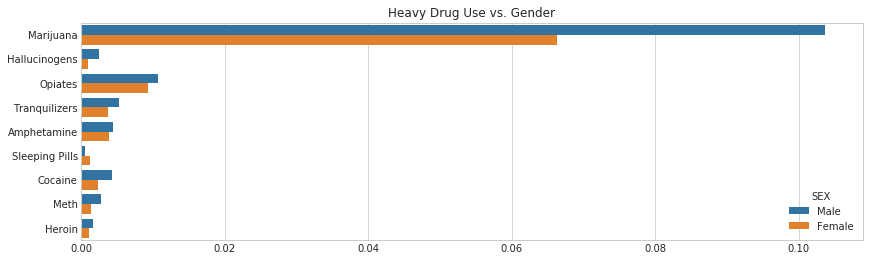

In [26]:
plt.figure(figsize=(14,4)) # plot re-size
ax = sns.barplot(orient="h", y="drug", x="drug use", hue="SEX", ci=None, data=heavy_use2)
ax.set_ylabel('') 
ax.set_xlabel('') 
ax.set_title('Heavy Drug Use vs. Gender')

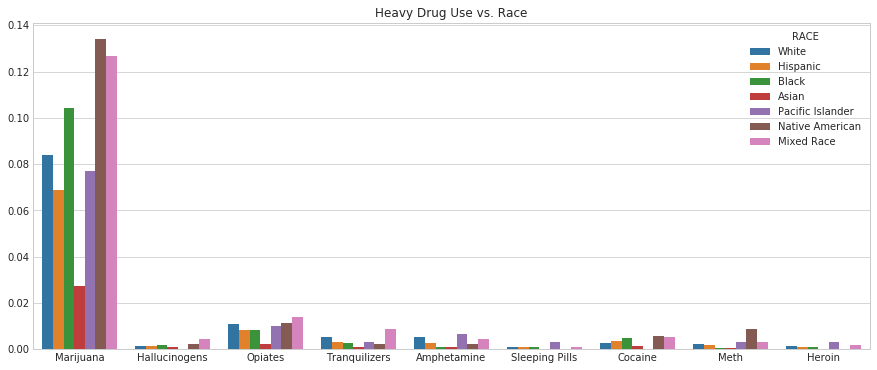

In [27]:
plt.figure(figsize=(15,6))
ax = sns.barplot(orient="v", x="drug", y="drug use", hue="RACE", 
            hue_order=["White", "Hispanic", "Black", "Asian", "Pacific Islander", "Native American", "Mixed Race"],
            data=heavy_use2, dodge=True, ci=None)
ax.set_ylabel('') 
ax.set_xlabel('') 
ax.set_title('Heavy Drug Use vs. Race')

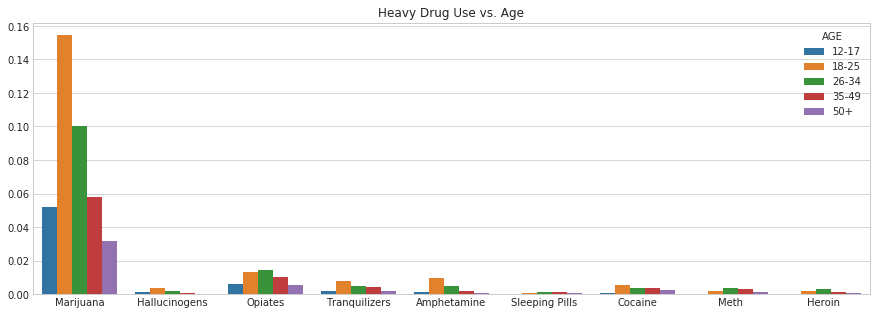

In [28]:
plt.figure(figsize=(15,5)) # plot re-size
ax = sns.barplot(orient="v", x="drug", y="drug use", hue="AGE", hue_order=["12-17", "18-25", "26-34", "35-49", 
                                                                  "50+"], ci=None, data=heavy_use2)
ax.set_title('Heavy Drug Use vs. Age')
ax.set_xlabel('') 
ax.set_ylabel('') 

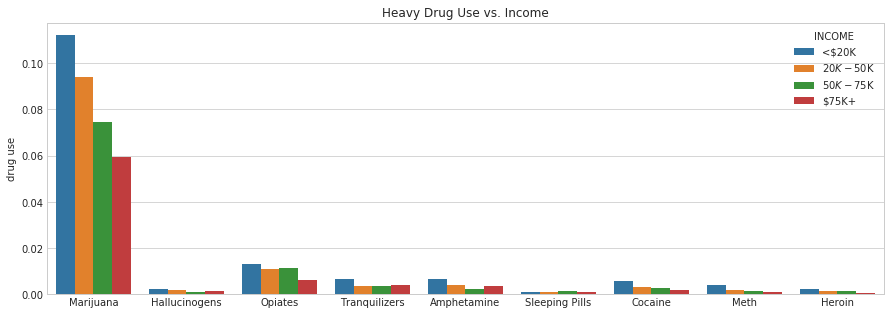

In [29]:
plt.figure(figsize=(15,5)) # plot re-size
ax = sns.barplot(orient="v", x="drug", y="drug use", hue="INCOME", 
            hue_order=["<$20K", "$20K-$50K", "$50K-$75K", "$75K+"], ci=None, data=heavy_use2)
ax.set_xlabel('') 
ax.set_title('Heavy Drug Use vs. Income')

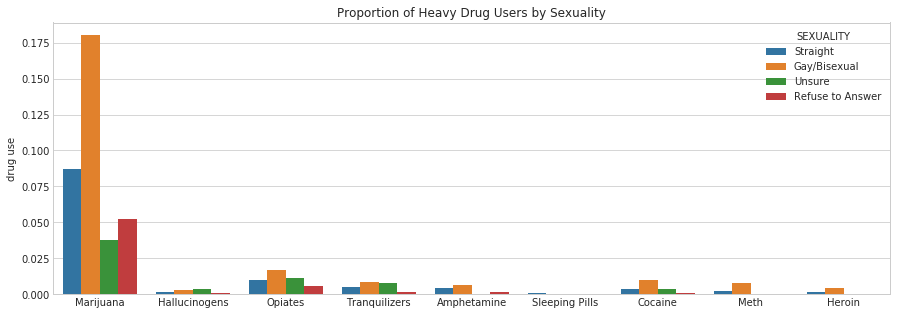

In [30]:
plt.figure(figsize=(15,5)) # plot re-size
ax = sns.barplot(orient="v", x="drug", y="drug use", hue="SEXUALITY", 
                 hue_order=["Straight", "Gay/Bisexual", "Unsure", "Refuse to Answer"],
            ci=None, data=heavy_use2)
ax.set_title("Proportion of Heavy Drug Users by Sexuality")
ax.set_xlabel('') 

# Appendix A: Other Drugs

For curiosity, here are the usage rates for every substance listed. 

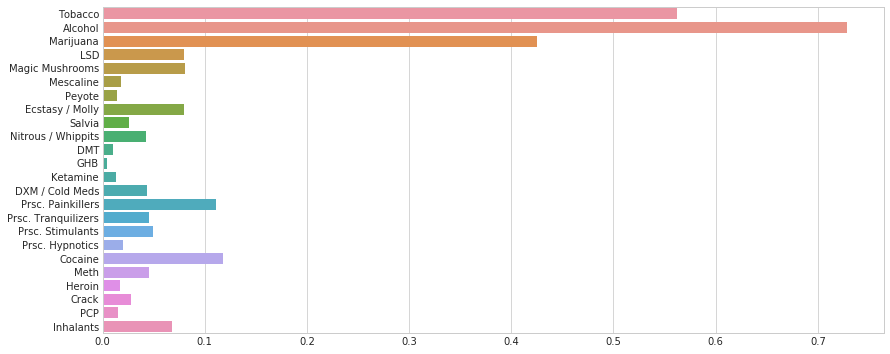

In [31]:
ever_tried_bonus = df[["TOBFLAG", "ALCFLAG", "MRJFLAG", "LSDFLAG", "PSILCY2", "MESC2", "PEYOTE2", "ECSTMOFLAG", "SALVIAFLAG", "NITOXID2", "DAMTFXFLAG", "GHBFLGR", "KETMINFLAG", "COLDFLGR", 
                "PNRNMFLAG", "TRQNMFLAG", "STMNMFLAG", "SEDNMFLAG", "COCFLAG", "METHAMFLAG", "HERFLAG", 
                 "CRKFLAG", "PCPFLAG"]]

# wanted to separate out nitrous oxide (laughing gas / whippits) use from household inhalants due to radically
# different use rates and risk profiles
Inhalants = df[["CLEFLU2", "GAS2", "GLUE2", "ETHER2", "SOLVENT2", "LGAS2", "FELTMARKR2", "SPPAINT2", "AIRDUSTER2", "OTHAEROS2"]]
Inhalants = Inhalants.sum(axis=1)
Inhalants[Inhalants>0] = 1
ever_tried_bonus = ever_tried_bonus.assign(Inhalants = Inhalants)

ever_tried_bonus.columns = ["Tobacco", "Alcohol", "Marijuana", "LSD", "Magic Mushrooms", "Mescaline", "Peyote", "Ecstasy / Molly", "Salvia", "Nitrous / Whippits", "DMT",  "GHB", "Ketamine", 
                     "DXM / Cold Meds", "Prsc. Painkillers", "Prsc. Tranquilizers", "Prsc. Stimulants", 
                      "Prsc. Hypnotics", "Cocaine", "Meth", "Heroin", "Crack", "PCP", "Inhalants"]

ever_tried_bonus[:5]
plt.figure(figsize=(14,6))
sns.barplot(orient="h", ci=None, data=ever_tried_bonus)

Here are the most widely-tried drugs, nicely ordered, by adults in the United States.

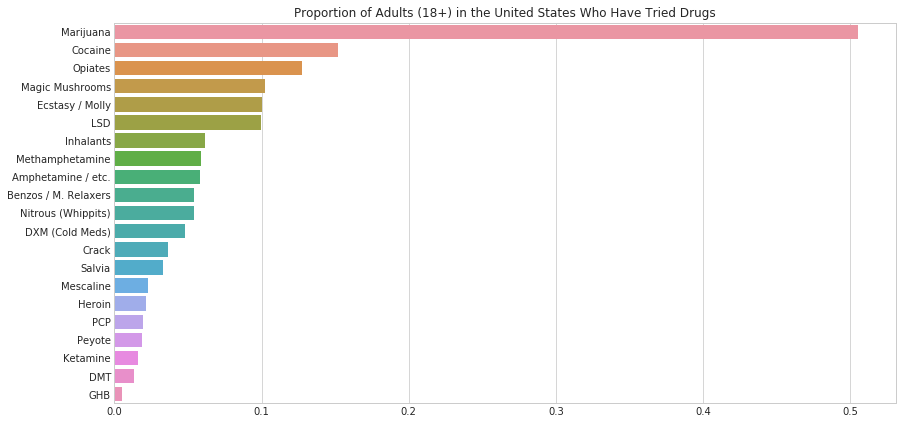

In [32]:
ever_tried_bonus = df[df["CATAGE"]>1][["MRJFLAG", "LSDFLAG", "PSILCY2", "MESC2", "PEYOTE2", "ECSTMOFLAG", "SALVIAFLAG", "NITOXID2", "DAMTFXFLAG", "GHBFLGR", "KETMINFLAG", "COLDFLGR", 
                "PNRNMFLAG", "TRQNMFLAG", "STMNMFLAG", "SEDNMFLAG", "COCFLAG", "METHAMFLAG", "HERFLAG", 
                 "CRKFLAG", "PCPFLAG"]]
Inhalants = df[df["CATAGE"]>1][["CLEFLU2", "GAS2", "GLUE2", "ETHER2", "SOLVENT2", "LGAS2", "FELTMARKR2", "SPPAINT2", "AIRDUSTER2", "OTHAEROS2"]]
Inhalants = Inhalants.sum(axis=1)
Inhalants[Inhalants>0] = 1
ever_tried_bonus = ever_tried_bonus.assign(Inhalants = Inhalants)

ever_tried_bonus.columns = ["Marijuana", "LSD", "Magic Mushrooms", "Mescaline", "Peyote", "Ecstasy / Molly", "Salvia", "Nitrous (Whippits)", "DMT",  "GHB", "Ketamine", 
                     "DXM (Cold Meds)", "Opiates", "Benzos / M. Relaxers", "Amphetamine / etc.", 
                      "Hypnotics / Sleeping Pills", "Cocaine", "Methamphetamine", "Heroin", "Crack", "PCP", "Inhalants"]

ever_tried_bonus[:5]
plt.figure(figsize=(14,7))
ax = sns.barplot(orient="h", ci=None, data=ever_tried_bonus,
           order=["Marijuana", "Cocaine", "Opiates", "Magic Mushrooms", "Ecstasy / Molly", "LSD", "Inhalants", "Methamphetamine", 
                 "Amphetamine / etc.", "Benzos / M. Relaxers", "Nitrous (Whippits)", "DXM (Cold Meds)", "Crack", 
                 "Salvia", "Mescaline", "Heroin", "PCP", "Peyote",  "Ketamine", "DMT", "GHB"])
ax.set_title("Proportion of Adults (18+) in the United States Who Have Tried Drugs")

Here are the most widely-tried drugs, nicely ordered, by middle-school and high-school aged students in the United States.

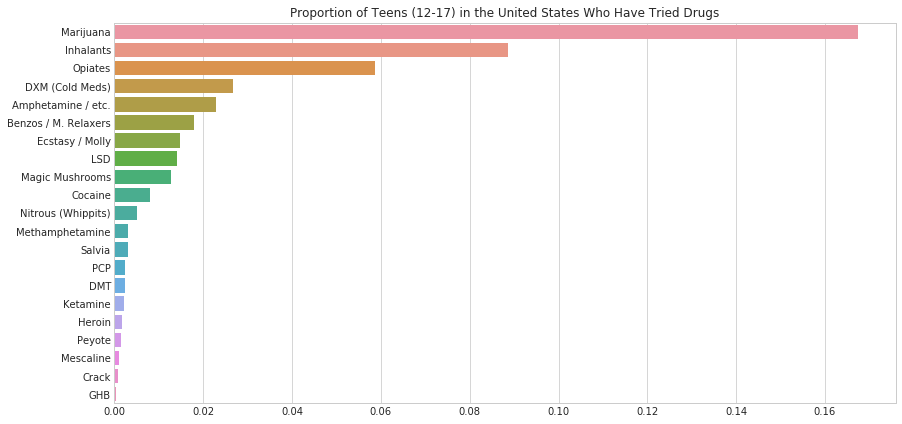

In [33]:
ever_tried_bonus = df[df["CATAGE"]==1][["MRJFLAG", "LSDFLAG", "PSILCY2", "MESC2", "PEYOTE2", "ECSTMOFLAG", "SALVIAFLAG", "NITOXID2", "DAMTFXFLAG", "GHBFLGR", "KETMINFLAG", "COLDFLGR", 
                "PNRNMFLAG", "TRQNMFLAG", "STMNMFLAG", "SEDNMFLAG", "COCFLAG", "METHAMFLAG", "HERFLAG", 
                 "CRKFLAG", "PCPFLAG"]]

Inhalants = df[df["CATAGE"]==1][["CLEFLU2", "GAS2", "GLUE2", "ETHER2", "SOLVENT2", "LGAS2", "FELTMARKR2", "SPPAINT2", "AIRDUSTER2", "OTHAEROS2"]]
Inhalants = Inhalants.sum(axis=1)
Inhalants[Inhalants>0] = 1
ever_tried_bonus = ever_tried_bonus.assign(Inhalants = Inhalants)

ever_tried_bonus.columns = ["Marijuana", "LSD", "Magic Mushrooms", "Mescaline", "Peyote", "Ecstasy / Molly", "Salvia", "Nitrous (Whippits)", "DMT",  "GHB", "Ketamine", 
                     "DXM (Cold Meds)", "Opiates", "Benzos / M. Relaxers", "Amphetamine / etc.", 
                      "Hypnotics / Sleeping Pills", "Cocaine", "Methamphetamine", "Heroin", "Crack", "PCP", "Inhalants"]

plt.figure(figsize=(14,7))
ax = sns.barplot(orient="h", ci=None, data=ever_tried_bonus,
           order=["Marijuana", "Inhalants", "Opiates", "DXM (Cold Meds)", "Amphetamine / etc.", "Benzos / M. Relaxers", 
                  "Ecstasy / Molly", "LSD", "Magic Mushrooms", "Cocaine", "Nitrous (Whippits)",  "Methamphetamine", 
                 "Salvia", "PCP", "DMT", "Ketamine", "Heroin",  "Peyote", "Mescaline",  "Crack", "GHB"])
ax.set_title("Proportion of Teens (12-17) in the United States Who Have Tried Drugs")